In [26]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Metriche_di_performance as mdp

In [27]:
def crea_dati_bitcoin(start_date, end_date):
    """
    Scarica i dati storici di Bitcoin in euro da Yahoo Finance tra le date start_date e end_date,
    crea un DataFrame con le colonne 'Timestamp' e 'Price', e visualizza il grafico dei prezzi.
    """
    # Scarica i dati da Yahoo Finance (BTC-EUR per i prezzi di Bitcoin in euro)
    btc_data = yf.download('BTC-EUR', start=start_date, end=end_date)
    
    # Crea il DataFrame con Timestamp e Price (utilizzando la colonna 'Close' per il prezzo)
    dati = pd.DataFrame({
        'Timestamp': btc_data.index,
        'Price': btc_data['Close']
    })
    
    # Visualizza il grafico dell'andamento dei prezzi
    plt.figure(figsize=(10, 6))
    plt.plot(dati['Timestamp'], dati['Price'], label='Bitcoin Price (EUR)', color='b')
    plt.xlabel('Date')
    plt.ylabel('Price (EUR)')
    plt.title(f'Bitcoin Price in EUR from {start_date} to {end_date}')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return dati

[*********************100%***********************]  1 of 1 completed


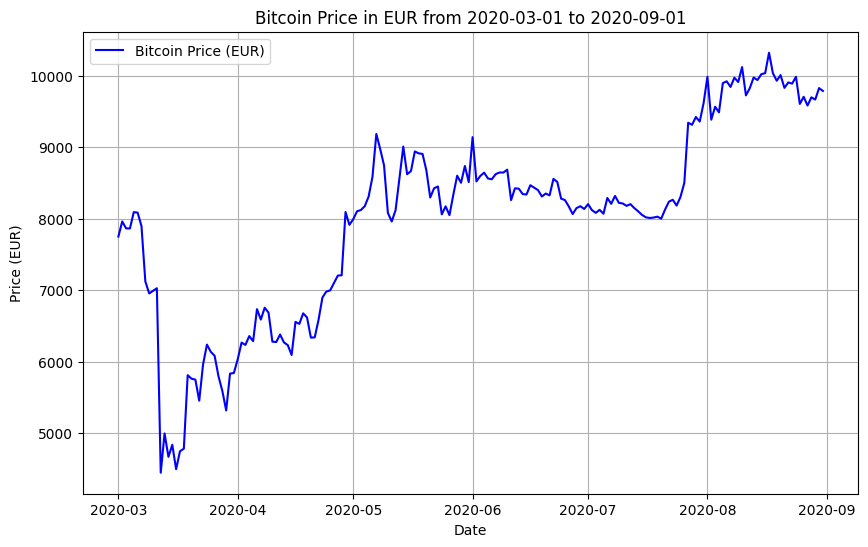

In [28]:
# Esempio di utilizzo:
start_date = '2020-03-01'
end_date = '2020-09-01'
dati = crea_dati_bitcoin(start_date, end_date)

In [29]:
def normalizza_matrice(matrice, exception_cells):
    """
    Normalizza una matrice tenendo conto delle celle da escludere.
    """
    # Creiamo una copia della matrice originale per evitare modifiche in-place
    matrice = matrice.copy()
    
    # Imposta a zero le celle in exception_cells
    for cella in exception_cells:
        matrice[cella[0], cella[1]] = 0

    # Normalizza la matrice in modo che la somma delle celle sia 1
    somma_totale = np.sum(matrice)
    
    if somma_totale == 0:
        raise ValueError("La somma delle celle nella matrice, escluse le eccezioni, è 0. Non è possibile normalizzare.")
    
    matrice /= somma_totale
    return matrice

In [30]:
def simula_trading(dati, righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure, liquidità_iniziale, bitcoin_iniziali):
    if not matrice_liquidità[0]:
        matrice_liquidità = np.full((righe, colonne), 1 / (righe * colonne))

    if not matrice_bitcoin[0]:
        matrice_bitcoin = np.full((righe, colonne), 1 / (righe * colonne))

    # Controllo sugli max_exp_acquisto e max_exp_vendita
    if not (isinstance(max_exp_acquisto, int) and max_exp_acquisto <= 0):
        raise ValueError("max_exp_acquisto deve essere un intero non positivo.")
    if not (isinstance(max_exp_vendita, int) and max_exp_vendita <= 0):
        raise ValueError("max_exp_vendita deve essere un intero non positivo.")
    
    # Convertiamo i dati di input in numpy array per efficienza
    matrice_liquidità = np.array(matrice_liquidità)
    matrice_bitcoin = np.array(matrice_bitcoin)
    
    # Controlli iniziali: Verifichiamo che la somma delle celle faccia 1
    if not np.isclose(np.sum(matrice_liquidità), 1) or not np.isclose(np.sum(matrice_bitcoin), 1):
        raise ValueError("Le matrici non sono normalizzate correttamente, la somma delle loro celle deve essere 1.")
    
    if base_acquisto < 1 or base_vendita < 1:
        raise ValueError("Attenzione! base_vendita e base_acquisto devono essere entrambi almeno 1.")
    
    # Normalizzazione delle matrici se ci sono eccezioni
    if exception_cells:
        matrice_liquidità = normalizza_matrice(matrice_liquidità, exception_cells)
        matrice_bitcoin = normalizza_matrice(matrice_bitcoin, exception_cells)
    
    # Estrazione dei dati sui prezzi
    prezzi = dati['Price'].values
    date = dati['Timestamp'].values
    
    # Inizializzo le quantità parziali di liquidità e bitcoin per ogni strategia
    liquidità_parziale = matrice_liquidità * liquidità_iniziale
    bitcoin_parziale = matrice_bitcoin * bitcoin_iniziali
    
    # Mantengo una copia della liquidità dopo l'ultima ridistribuzione, se necessario
    liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale) if riferimento_iniziale_acquisto else None
    
    # DataFrame per tenere traccia delle transazioni giornaliere
    transazioni_giornaliere = []
    
    # Variabili per tenere traccia di stato acquisto/vendita per ogni strategia
    acquisto_contatori = np.zeros_like(matrice_liquidità)
    vendita_contatori = np.zeros_like(matrice_bitcoin)
    prezzo_medio_acquisto = np.zeros_like(matrice_bitcoin)
    euro_spesi_acquisto = np.zeros_like(matrice_bitcoin)  # Tieni traccia degli euro spesi durante l'ultima scia di acquisti
    in_scia_acquisto = np.zeros_like(matrice_bitcoin, dtype=bool)  # Flag per indicare se siamo in una scia di acquisti
    
    # Loop sui giorni
    for giorno in range(1, len(prezzi)):  # Inizia da 1 perché confrontiamo con il giorno precedente
        prezzo_corrente = prezzi[giorno]
        prezzo_precedente = prezzi[giorno - 1]
        
        # Calcolo la liquidità e i bitcoin totali all'inizio del giorno
        liquidità_inizio_giorno = np.sum(liquidità_parziale)
        bitcoin_inizio_giorno = np.sum(bitcoin_parziale)
        
        # Variabili per tenere traccia delle transazioni giornaliere
        euro_spesi_giorno = 0
        euro_guadagnati_giorno = 0
        bitcoin_guadagnati_giorno = 0
        bitcoin_venduti_giorno = 0
        
        # Loop su tutte le strategie
        for i in range(matrice_liquidità.shape[0]):
            for j in range(matrice_liquidità.shape[1]):
                if (i, j) in exception_cells:
                    continue
                
                # Acquisto: Se il prezzo scende e ho liquidità
                if prezzo_corrente < prezzo_precedente:
                    # Determina la liquidità di riferimento
                    if riferimento_iniziale_acquisto:
                        liquidità_riferimento = liquidità_iniziale_ridistribuzione[i, j]
                    else:
                        liquidità_riferimento = liquidità_parziale[i, j]
                    
                    # Determina la percentuale di acquisto in base alla progressione geometrica
                    percentuale_acquisto = min(base_acquisto ** max_exp_acquisto, base_acquisto ** (max_exp_acquisto - i + acquisto_contatori[i, j]))
                    euro_da_spendere = percentuale_acquisto * liquidità_riferimento
                    
                    # Se la liquidità da spendere è maggiore della liquidità attuale
                    if euro_da_spendere > liquidità_parziale[i, j]:
                        if compra_pure:
                            euro_acquisto = liquidità_parziale[i, j]  # Spendi tutto quello che hai
                        else:
                            continue  # Non comprare niente
                    else:
                        euro_acquisto = euro_da_spendere
                    
                    # Aggiorna liquidità e bitcoin
                    liquidità_parziale[i, j] -= euro_acquisto
                    bitcoin_acquistati = euro_acquisto / prezzo_corrente
                    bitcoin_parziale[i, j] += bitcoin_acquistati
                    
                    # Aggiorna il prezzo medio pesato degli acquisti solo per la scia corrente
                    euro_spesi_acquisto[i, j] += euro_acquisto
                    prezzo_medio_acquisto[i, j] = (
                        prezzo_medio_acquisto[i, j] * (euro_spesi_acquisto[i, j] - euro_acquisto) + euro_acquisto * prezzo_corrente
                    ) / euro_spesi_acquisto[i, j]
                    
                    # Aggiorna il contatore degli acquisti e delle transazioni giornaliere
                    acquisto_contatori[i, j] += 1
                    euro_spesi_giorno += euro_acquisto
                    bitcoin_guadagnati_giorno += bitcoin_acquistati
                    vendita_contatori[i, j] = 0  # Reset contatore vendite per nuova discesa
                
                # Vendita: Se il prezzo sale e ho bitcoin
                elif prezzo_corrente > prezzo_precedente and bitcoin_parziale[i, j] > 0:
                    # Verifica se il prezzo corrente supera il prezzo medio pesato dell'ultima scia di acquisti
                    if prezzo_corrente > prezzo_medio_acquisto[i, j] * (1 + soglia_vendita):
                        # Reset della scia di acquisti e inizio della scia di vendite
                        in_scia_acquisto[i, j] = False

                        percentuale_vendita = min(base_vendita ** max_exp_vendita, base_vendita ** (max_exp_vendita - j + vendita_contatori[i, j]))
                        bitcoin_da_vendere = percentuale_vendita * bitcoin_parziale[i, j]
                        
                        # Aggiorna bitcoin e liquidità
                        bitcoin_parziale[i, j] -= bitcoin_da_vendere
                        euro_venduti = bitcoin_da_vendere * prezzo_corrente
                        liquidità_parziale[i, j] += euro_venduti
                        
                        # Aggiorna le transazioni giornaliere
                        euro_guadagnati_giorno += euro_venduti
                        bitcoin_venduti_giorno += bitcoin_da_vendere
                        
                        # Incrementa il contatore delle vendite
                        vendita_contatori[i, j] += 1
                        acquisto_contatori[i, j] = 0  # Reset contatore acquisti per nuova salita

        # Calcolo le percentuali di liquidità e bitcoin usati per le transazioni
        percentuale_liquidità_usata = euro_spesi_giorno / liquidità_inizio_giorno if liquidità_inizio_giorno > 0 else 0
        percentuale_bitcoin_venduti = bitcoin_venduti_giorno / bitcoin_inizio_giorno if bitcoin_inizio_giorno > 0 else 0
        
        # Calcolo il valore del portafoglio totale alla fine del giorno
        valore_liquidità_totale = np.sum(liquidità_parziale)
        numero_totale_bitcoin = np.sum(bitcoin_parziale)
        valore_bitcoin_totale = numero_totale_bitcoin * prezzo_corrente
        valore_totale_giornaliero = valore_liquidità_totale + valore_bitcoin_totale
        
        # Salvo i dati delle transazioni giornaliere
        transazioni_giornaliere.append({
            'data': date[giorno],
            'prezzo': prezzo_corrente,
            'euro spesi': euro_spesi_giorno,
            'euro guadagnati': euro_guadagnati_giorno,
            'bitcoin venduti': bitcoin_venduti_giorno,
            'bitcoin guadagnati': bitcoin_guadagnati_giorno,
            'percentuale liquidità usata': percentuale_liquidità_usata,
            'percentuale bitcoin venduti': percentuale_bitcoin_venduti,
            'liquidità totale': valore_liquidità_totale,
            'bitcoin': numero_totale_bitcoin,
            'valore bitcoin totali': valore_bitcoin_totale,
            'valore_totale_portafoglio': valore_totale_giornaliero
        })
        
        # Ogni "giorni_ridistribuzione" giorni, facciamo la ridistribuzione
        if (giorno + 1) % giorni_ridistribuzione == 0:
            # Somma totale di liquidità e bitcoin attuali
            liquidità_totale = np.sum(liquidità_parziale)
            bitcoin_totale = np.sum(bitcoin_parziale)

            # # Normalizzazione delle matrici se ci sono eccezioni
            # if exception_cells:
            #     matrice_liquidità = normalizza_matrice(matrice_liquidità, exception_cells)
            #     matrice_bitcoin = normalizza_matrice(matrice_bitcoin, exception_cells)
            
            # Ridistribuisco la liquidità e i bitcoin parziali in base alle matrici
            liquidità_parziale = matrice_liquidità * liquidità_totale
            bitcoin_parziale = matrice_bitcoin * bitcoin_totale
            
            # Se riferimento_iniziale_acquisto è True, aggiorno la liquidità di riferimento
            if riferimento_iniziale_acquisto:
                liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale)

    # Converto le transazioni giornaliere in un DataFrame
    df_transazioni = pd.DataFrame(transazioni_giornaliere)
    
    return df_transazioni

In [31]:
# Parametri fissi
liquidità_iniziale = 1000
bitcoin_iniziali = 0

# Parametri variabili
righe = 3
colonne = 1
matrice_liquidità = [[]]
matrice_bitcoin = matrice_liquidità # np.full((righe, colonne), 1 / (righe * colonne)) # [[0.25, 0.25], [0.25, 0.25]]
exception_cells = [(0, 0), (1, 0)]
giorni_ridistribuzione = 7
base_acquisto = 1.005
base_vendita = 1.08
soglia_vendita = -np.inf
max_exp_acquisto = 0 # Intero non positivo
max_exp_vendita = -1 # Intero non positivo
riferimento_iniziale_acquisto = True # Se è True, le percentuali non vengono riferite alla liquidità posseduta in quel momento, ma alla liquidità posseduta subito dopo l'ultima ridistribuzione (quindi potrebbe risultare anche che bisogna spendere più di quel che si ha, e in quel caso si spende tutto solo se compra_pure = True, altrimenti non si spende niente)
compra_pure = False # Utile solo se riferimento_iniziale_acquisto è True, altrimenti il suo valore è indifferente

df_transazioni = simula_trading(dati, righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure, liquidità_iniziale, bitcoin_iniziali)
df_transazioni

,data,prezzo,euro spesi,euro guadagnati,bitcoin venduti,bitcoin guadagnati,percentuale liquidità usata,percentuale bitcoin venduti,liquidità totale,bitcoin,valore bitcoin totali,valore_totale_portafoglio
0,2020-03-02,7959.358398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,1000.000000
1,2020-03-03,7862.485352,990.074503,0.000000,0.000000,0.125924,0.990075,0.000000,9.925497,0.125924,990.074503,1000.000000
2,2020-03-04,7861.055176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.925497,0.125924,989.894410,999.819907
3,2020-03-05,8089.786133,0.000000,943.238051,0.116596,0.000000,0.000000,0.925926,953.163548,0.009328,75.459044,1028.622592
4,2020-03-06,8082.739746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,953.163548,0.009328,75.393318,1028.556865
...,...,...,...,...,...,...,...,...,...,...,...,...
178,2020-08-27,9581.077148,1328.981689,0.000000,0.000000,0.138709,0.972589,0.000000,37.455382,0.149757,1434.828827,1472.284209
179,2020-08-28,9695.468750,0.000000,1344.407145,0.138663,0.000000,0.000000,0.925926,1381.862527,0.011093,107.552572,1489.415098
180,2020-08-29,9664.351562,1328.981689,0.000000,0.000000,0.137514,0.961732,0.000000,52.880838,0.148607,1436.189075,1489.069913
181,2020-08-30,9824.922852,0.000000,1351.899141,0.137599,0.000000,0.000000,0.925926,1404.779979,0.011008,108.151931,1512.931910


In [32]:
# Funzione per calcolare la dimensione dei punti nel grafico
def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

In [33]:
# Funzione per plottare il grafico delle transazioni
def plot_transazioni(dati, transazioni, etichette=True):
    acquisti = transazioni[transazioni['bitcoin guadagnati'] > 0]
    vendite = transazioni[transazioni['bitcoin venduti'] > 0]

    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['euro spesi'].max() if not acquisti.empty else 0
    max_vendita = vendite['euro guadagnati'].max() if not vendite.empty else 0

    dimensioni_acquisti = acquisti['euro spesi'].apply(lambda x: calcola_dimensione(x, max_acquisto)) if max_acquisto > 0 else []
    dimensioni_vendite = vendite['euro guadagnati'].apply(lambda x: calcola_dimensione(x, max_vendita)) if max_vendita > 0 else []

    # Creazione del grafico
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
        if etichette:
            for i, row in acquisti.iterrows():
                plt.text(row['data'], row['prezzo'], f"+{row['euro spesi']:.2f} €", 
                         color='black', ha='center', va='bottom')
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
        if etichette:
            for i, row in vendite.iterrows():
                plt.text(row['data'], row['prezzo'], f"-{row['euro guadagnati']:.2f} €", 
                         color='black', ha='center', va='top')

    plt.xlabel('Data')
    plt.ylabel('Prezzo')
    plt.title('Andamento dei prezzi e transazioni')
    plt.legend()
    plt.show()

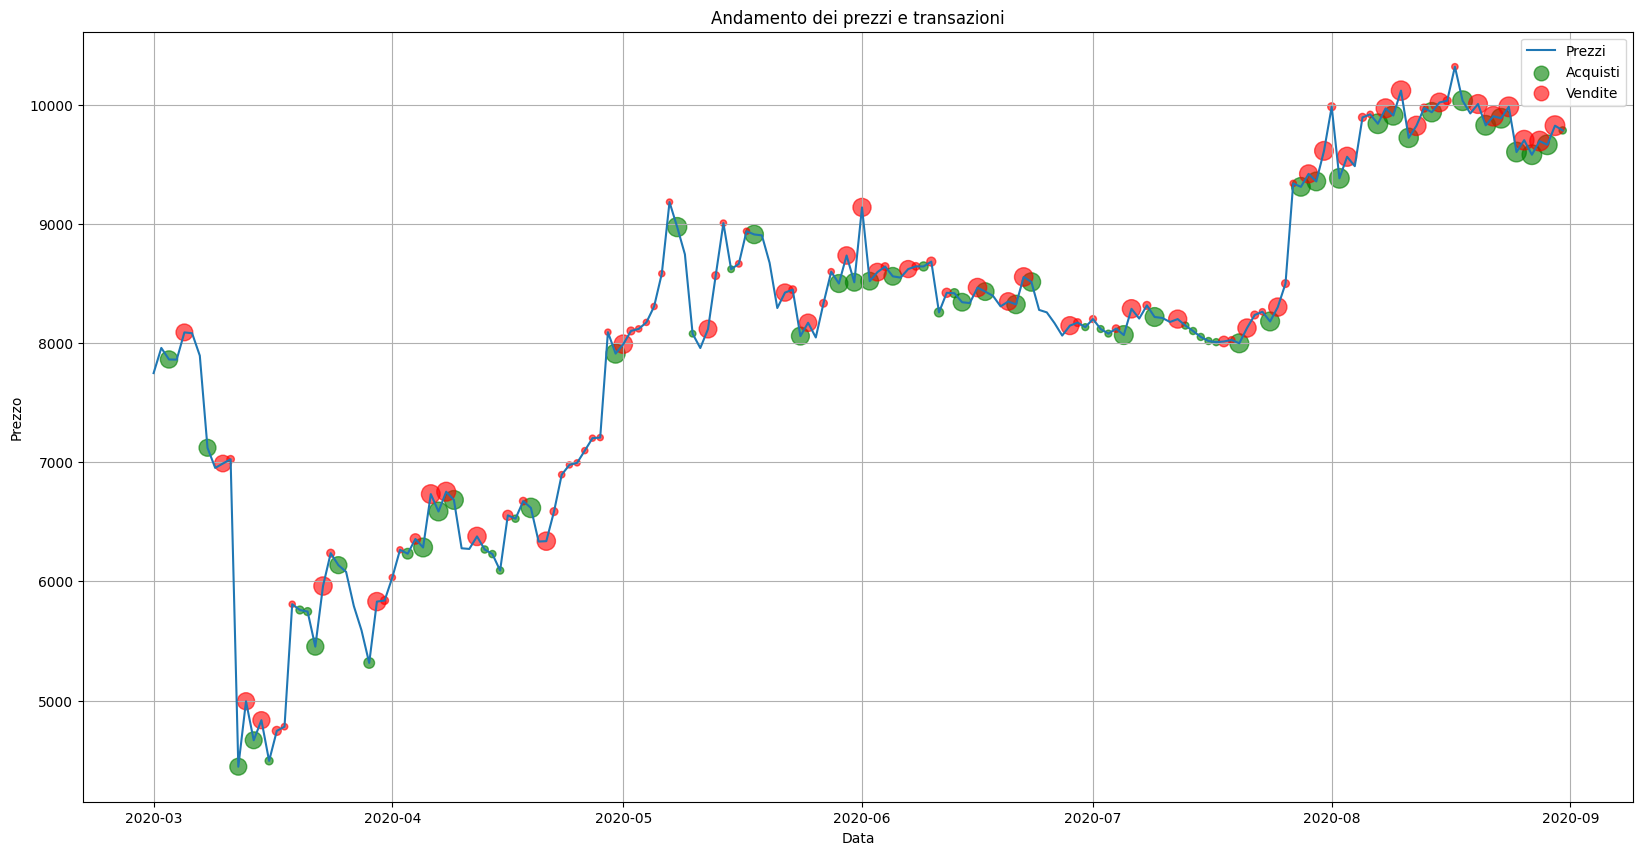

In [34]:
plot_transazioni(dati, df_transazioni, etichette=False)

In [35]:
list_transactions = []
list_transactions.append([df_transazioni['valore_totale_portafoglio'], df_transazioni['prezzo'], df_transazioni['bitcoin']])

# Calcolo delle metriche di performance per ogni dataset usando le funzioni della libreria 'mdp'
media_max_drawdown = np.mean([mdp.max_drawdown(trans[0]) for trans in list_transactions])
media_volatilita = np.mean([mdp.volatility(trans[0]) for trans in list_transactions])
media_sharpe_ratio = np.mean([mdp.sharpe_ratio(trans[0]) for trans in list_transactions])
media_sortino_ratio = np.mean([mdp.sortino_ratio(trans[0]) for trans in list_transactions])
media_calmar_ratio = np.mean([mdp.calmar_ratio(trans[0]) for trans in list_transactions])
media_profit_factor = np.mean([mdp.profit_factor(trans[1], trans[2]) for trans in list_transactions])
media_pnl_per_trade = np.mean([np.mean(mdp.calcola_pnl(trans[1], trans[2])) for trans in list_transactions])

# Stampa delle metriche calcolate
print(f'Media max drawdown: {media_max_drawdown:.2f}%')
print(f'Media volatilità: {media_volatilita:.2f}')
print(f'Media Sharpe ratio: {media_sharpe_ratio:.2f}')
print(f'Media Sortino ratio: {media_sortino_ratio:.2f}')
print(f'Media Calmar ratio: {media_calmar_ratio:.2f}')
print(f'Media Profit factor: {media_profit_factor:.2f}')
print(f'Media PnL per trade: {media_pnl_per_trade:.2f}')

Media max drawdown: 20.49%
Media volatilità: 0.31
Media Sharpe ratio: 1.99
Media Sortino ratio: 3.95
Media Calmar ratio: 2.50
Media Profit factor: 2.29
Media PnL per trade: 5.62


In [36]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [37]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(dati['Price'], liquidità_iniziale, bitcoin_iniziali)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 10.87583904301289
Portafoglio finale ideale in euro: 10875.83904301289


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_444144\1732262686.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_444144\1732262686.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_444144\1732262686.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

In [39]:
valore_iniziale = df_transazioni['valore_totale_portafoglio'].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [40]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio considerato sufficiente: {round(1 / rendimento_ideale * 100, 2)}%')
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale * 100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['valore_totale_portafoglio'].iloc[-1]}")

Rendimento del portafoglio: 1.512492700882129
Punteggio considerato sufficiente: 9.19%
Punteggio rendimento: 13.91%
Valore finale del portafoglio in euro: 1512.492700882129
